In [1]:
#!pip install axelrod
#!conda list freetype

In [62]:
import axelrod as axl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [63]:
players = [axl.TitForTat(), axl.FirstByTidemanAndChieruzzi(), axl.FirstByNydegger(), axl.FirstByGrofman(), axl.FirstByShubik(),
             axl.FirstBySteinAndRapoport(), axl.Grudger(), axl.FirstByDavis(), axl.FirstByGraaskamp(), axl.FirstByDowning(),
             axl.FirstByFeld(), axl.FirstByJoss(), axl.FirstByTullock(), axl.FirstByAnonymous(), axl.Random()]


num_players = len(players)
num_reps = 5
num_turns = 200

In [64]:
tournament = axl.Tournament(players=players, repetitions=num_reps, turns=num_turns)
results = tournament.play(build_results = True, filename="results.csv")

Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 52.99it/s]


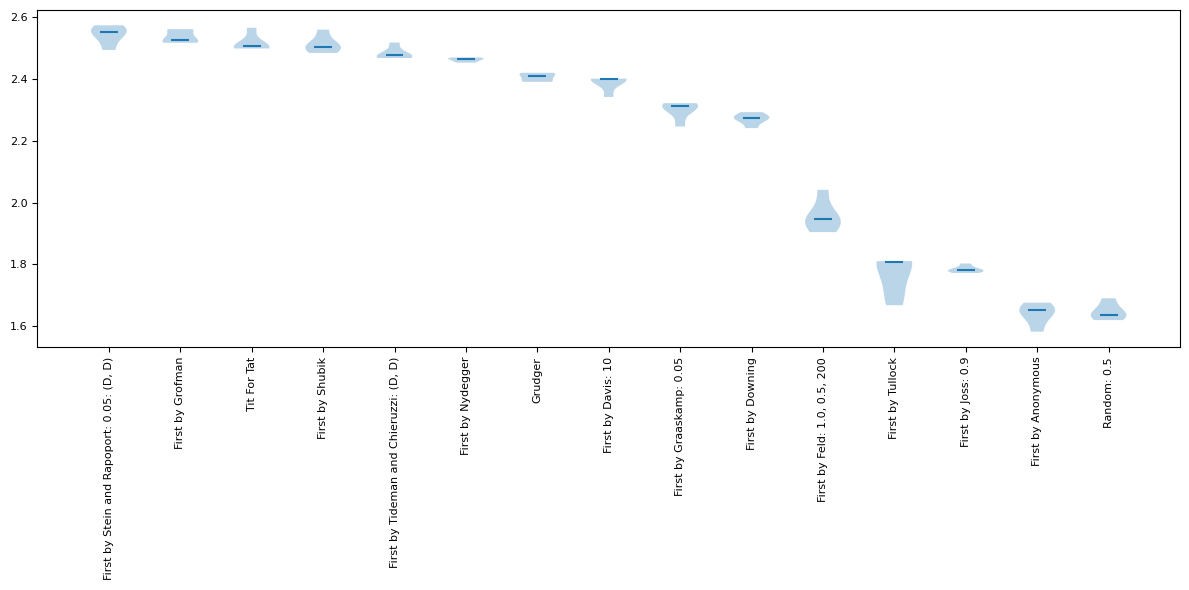

In [65]:
%matplotlib inline
plot = axl.Plot(results)
p = plot.boxplot()
p

In [66]:
results.write_summary("summary.csv")

In [67]:
results.wins

[[0, 0, 0, 0, 0],
 [10, 11, 10, 11, 11],
 [0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1],
 [3, 3, 3, 3, 3],
 [10, 10, 10, 10, 10],
 [5, 5, 5, 5, 5],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [7, 7, 7, 7, 7],
 [9, 8, 9, 10, 10],
 [11, 12, 8, 12, 11],
 [8, 9, 9, 8, 8],
 [2, 3, 2, 3, 3],
 [2, 3, 4, 4, 4]]

In [68]:
results.scores

[[7183, 7017, 7000, 7021, 6995],
 [6911, 6942, 6933, 7049, 6909],
 [6867, 6907, 6883, 6900, 6914],
 [7061, 7047, 7170, 7166, 7072],
 [6955, 7006, 7166, 7041, 7001],
 [6982, 7168, 7205, 7146, 7099],
 [6771, 6743, 6775, 6699, 6693],
 [6722, 6699, 6556, 6717, 6718],
 [6470, 6453, 6500, 6476, 6289],
 [6274, 6364, 6362, 6419, 6369],
 [5427, 5715, 5453, 5451, 5332],
 [4991, 4986, 5048, 4983, 4962],
 [5064, 4670, 5066, 5070, 4830],
 [4693, 4571, 4430, 4625, 4628],
 [4638, 4579, 4733, 4535, 4577]]

In [69]:
results.normalised_scores

[[2.5653571428571427, 2.5060714285714285, 2.5, 2.5075, 2.498214285714286],
 [2.4682142857142857,
  2.4792857142857145,
  2.4760714285714287,
  2.5174999999999996,
  2.4675000000000002],
 [2.4525,
  2.4667857142857144,
  2.4582142857142855,
  2.4642857142857144,
  2.4692857142857143],
 [2.521785714285714,
  2.516785714285714,
  2.560714285714286,
  2.559285714285714,
  2.525714285714286],
 [2.4839285714285713,
  2.5021428571428572,
  2.559285714285714,
  2.514642857142857,
  2.500357142857143],
 [2.4935714285714283,
  2.5599999999999996,
  2.5732142857142857,
  2.552142857142857,
  2.535357142857143],
 [2.418214285714286,
  2.408214285714286,
  2.419642857142857,
  2.3924999999999996,
  2.3903571428571433],
 [2.400714285714286,
  2.3924999999999996,
  2.3414285714285716,
  2.3989285714285713,
  2.3992857142857145],
 [2.310714285714286,
  2.304642857142857,
  2.3214285714285716,
  2.312857142857143,
  2.2460714285714287],
 [2.2407142857142857,
  2.2728571428571427,
  2.2721428571428572,


In [70]:
results.payoffs[1] # this is a way to implement schulze method by match

[[3.0, 3.0, 3.0, 3.0, 3.0],
 [2.98, 2.98, 2.98, 2.98, 2.98],
 [3.02, 3.02, 3.02, 3.02, 3.02],
 [3.02, 3.0, 3.0, 3.0, 3.02],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [2.98, 2.98, 2.98, 2.98, 2.98],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0],
 [2.94, 3.01, 2.955, 2.98, 2.96],
 [1.165, 1.165, 1.165, 1.165, 1.165],
 [1.29, 1.28, 1.45, 1.48, 1.52],
 [1.065, 1.06, 1.04, 1.3, 1.07],
 [1.3, 1.39, 1.245, 1.27, 1.765],
 [2.73, 2.875, 2.98, 3.09, 2.35],
 [3.045, 2.93, 2.83, 2.96, 2.695]]

In [71]:
# Step 1: Build pairwise wins matrix
pairwise_wins = np.zeros((num_players, num_players), dtype=float)

for strat_1 in range(num_players):
    for strat_2 in range(num_players):
        if strat_1 != strat_2:
            wins_1 = 0
            wins_2 = 0
            for rep in range(num_reps):
                score_1 = results.payoffs[strat_1][strat_2][rep]
                score_2 = results.payoffs[strat_2][strat_1][rep]
                if score_1 > score_2:
                    wins_1 += round((score_1-score_2) * num_turns)
            # Save total wins from strat_1 over strat_2
            pairwise_wins[strat_1][strat_2] = wins_1
        else:
            pairwise_wins[strat_1][strat_2] = np.nan    

print("Pairwise wins matrix:\n", pairwise_wins)

Pairwise wins matrix:
 [[  nan    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [  25.   nan   50.   35.   25.    0.   25.   25.  180.  150.    0.    0.
    15. 1850. 2080.]
 [   0.    0.   nan    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]
 [   0.    0.    0.   nan    0.    0.    0.    0.  380.    0.    0.    0.
     0.    0.    0.]
 [   0.    0.    0.    0.   nan    0.    0.    0. 1455.    0.    0.    0.
     0. 1535. 1635.]
 [  25.    0.   50.   25.   25.   nan   25.   25.   25. 1425.    0.    0.
     0. 1745. 1605.]
 [   0.    0.    0.    0.    0.    0.   nan    0.  660.   50.    0.    0.
    85. 2450. 2285.]
 [   0.    0.    0.    0.    0.    0.    0.   nan  655.    0.    0.    0.
    65. 2165. 2295.]
 [   0.    0.  390.    0.    0.    0.    0.    0.   nan  385.    0.    0.
     0. 1720. 1800.]
 [   0.    0. 4825. 2800.   75.    0.    0.  125.    0.   nan    0.    0.
   150. 2525. 2470.]
 [  25.    0. 1175.  775.  

In [72]:
# Step 2: Apply Schulze method
def schulze_method(pairwise_matrix):
    n = len(pairwise_matrix)
    p = np.zeros((n, n), dtype=float)

    # Initialize p with direct wins
    for i in range(n):
        for j in range(n):
            if i != j:
                if pairwise_matrix[i][j] > pairwise_matrix[j][i]:
                    p[i][j] = pairwise_matrix[i][j]

    # Compute strongest paths
    for i in range(n):
        for j in range(n):
            if i != j:
                for k in range(n):
                    if i != k and j != k:
                        p[j][k] = max(p[j][k], min(p[j][i], p[i][k]))

    # Ranking: sort by number of wins in path strength
    ranking = sorted(range(n), key=lambda x: sum(p[x][y] > p[y][x] for y in range(n)), reverse=True)
    return ranking

ranking = schulze_method(pairwise_wins)

print("\nSchulze ranking:")
for pos, idx in enumerate(ranking, 1):
    print(f"{pos}. {players[idx]}")


Schulze ranking:
1. First by Joss: 0.9
2. First by Tideman and Chieruzzi: (D, D)
3. First by Feld: 1.0, 0.5, 200
4. First by Stein and Rapoport: 0.05: (D, D)
5. Grudger
6. First by Davis: 10
7. First by Tullock
8. First by Shubik
9. First by Graaskamp: 0.05
10. First by Downing
11. First by Anonymous
12. Random: 0.5
13. First by Grofman
14. Tit For Tat
15. First by Nydegger


In [73]:
results.ranked_names

['First by Stein and Rapoport: 0.05: (D, D)',
 'First by Grofman',
 'Tit For Tat',
 'First by Shubik',
 'First by Tideman and Chieruzzi: (D, D)',
 'First by Nydegger',
 'Grudger',
 'First by Davis: 10',
 'First by Graaskamp: 0.05',
 'First by Downing',
 'First by Feld: 1.0, 0.5, 200',
 'First by Tullock',
 'First by Joss: 0.9',
 'First by Anonymous',
 'Random: 0.5']

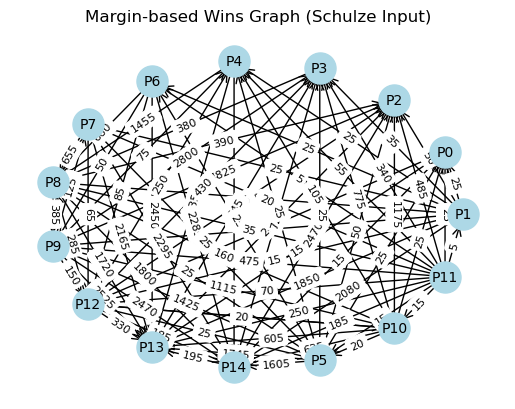

In [75]:
def plot_margin_graph(pairwise_wins, labels=None):
    """
    Plot weighted directed graph for pairwise margins.
    Positive weight means row player beats column player by that margin.
    """
    n = pairwise_wins.shape[0]
    G = nx.DiGraph()

    if labels is None:
        labels = [f"S{i}" for i in range(n)]

    # Add edges with weight
    for i in range(n):
        for j in range(n):
            if i != j and pairwise_wins[i][j] > 0:
                G.add_edge(labels[i], labels[j], weight=int(pairwise_wins[i][j]))

    # Layout
    pos = nx.circular_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges with thickness proportional to margin
    edges = G.edges(data=True)
    widths = [max(1, w['weight'] / max(pairwise_wins.flatten()) * 10) for (_, _, w) in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=widths, arrowstyle='->', arrowsize=15)

    # Add labels showing margins
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Margin-based Wins Graph (Schulze Input)")
    plt.axis("off")
    plt.show()

# Example usage:
a = plot_margin_graph(pairwise_wins, labels=[f"P{i}" for i in range(pairwise_wins.shape[0])])
a

### Some data analysis

In [ ]:
df = pd.read_csv("results.csv")

In [ ]:
df.columns